In [ ]:
# 传统文化：6733，7585，14318
# 分级诊疗：6658，3010，9668
# 共享单车：9346，7863，17209
# 轨道交通：6123，3642，9765
# 基础设施：9467，5610，15077
# 建筑垃圾：916，478，1394
# 科技创新：10275，4977，15252
# 科技创新中心：2131，1721，3852
# 垃圾分类：1446，1248，2694
# 老年代步车：993，1316，2309
# 美丽乡村：1704，638，2342
# 融合教育：79，699，778
# 文化遗产：6023，1051，7074
# 文化中心：5399，4190，9586
# 污泥处理：1582，192，1774
# 污泥利用：2119，649，2768
# 污水处理：2582，592，3174
# 物业管理：2944，1515，4459
# 学前教育：1190，740，1930
# 养老服务：1798，1023，2821
# 医疗机构：4983，1688，6671
# 再生资源：424，221，645
# 知识产权：2381，1559，3940
# 中小学生：5538，7268，12806
# 总：152306

In [1]:
#!/usr/bin/python
#-*- encoding:utf-8 -*-
from keras.layers import Activation, Dense,Embedding,LSTM,Bidirectional
from keras.models import Sequential        #序贯模型
from keras.preprocessing import sequence   #sequence.pad_sequences,用于统一句子长度
from sklearn.model_selection import train_test_split  #划分数据集
import jieba
jieba.load_userdict('/Users/lyj/Desktop/提案程序/sogou.txt')
jieba.load_userdict('/Users/lyj/Desktop/提案程序/标题补充词典.txt')
import numpy as np
import os
import re
import datetime

#读取stop停用词  
def readstopwords(stopwords_path): 
    stop_single_words=[]  
    with open(stopwords_path,'r+',encoding='utf-8') as lines:  
        for line in lines:
            content=line.strip()  
            stop_single_words.append(content) 
    return stop_single_words

#把文档中的所有文件名字存入数组
def getFilelist(data_path):
    txtNames = []                     #所有txt文档名字
    pathDir = os.listdir(data_path) #把文件夹里的所有txt文档的名字都获取了，放入数组
    for allDir in pathDir:
        if(allDir.find('txt') > 0 and allDir.find('result') < 0):
            txtNames.append(allDir)
    return txtNames 

def wordscounter(stop_single_words,data_path):
    sample_length=[]  #保存所有样本数据的长度
    num_recs = 0 #样本数
    word_freqs={} #存放所有的单词及次数
    txtNames=getFilelist(data_path)
    for txtname in txtNames:
        #print(txtname)
        with open(data_path+'/'+txtname,'r+',encoding='utf-8') as lines:
            for line in lines:
                #line=re.sub('[A-Za-z0-9,\d+(\.\d+)?\%]','',line) #正则化，去除字母,数字,百分数
                result=[] #为每句话定义一个空列表，存放分词结果
                sentence = line.strip()
                words = jieba.cut(sentence,cut_all=False)
                for word in words:
                    if word!=' ' and word not in stop_single_words:
                        word_ = ''.join(word.split())
                        result.append(word_)
                sample_length.append(len(result)) #存放所有样本数据的长度
                for word in result:
                    if word not in word_freqs.keys():
                        word_freqs[word]=1
                    else:
                        word_freqs[word]+=1
                num_recs += 1
    #句子长度对训练速度的影响特别大
    #max_len=int(max(sample_length))  #最大句子长度
    ave_len=int(np.mean(sample_length))  #平均句子长度
    #mode_len=int(np.argmax(np.bincount(sample_length))) #众数
    #median_len=int(np.median(sample_length)) #中位数
    #print(max_len,ave_len,mode_len,median_len)
    
    return num_recs,ave_len,word_freqs
            
        
# if __name__ == '__main__':
    
#starttime = datetime.datetime.now()

stopwords_path='/Users/lyj/Desktop/提案程序/百度停用词列表（去除英文）+tycb_symbol.txt'
data_path='/Users/lyj/Desktop/项目/数据/所有微博数据'



stop_single_words=readstopwords(stopwords_path)
data_num,avelen,word_freqs=wordscounter(stop_single_words,data_path)
#print(X,y)
#print('X和y的长度:',len(X),len(y))

# endtime = datetime.datetime.now()
# print ('运行时间为：',(endtime - starttime).seconds,'S')



/Applications/anaconda/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/x_/43mxrf_j66q5ynk5hsxw14lw0000gn/T/jieba.cache
Loading model cost 0.865 seconds.
Prefix dict has been built succesfully.


KeyboardInterrupt: 

In [2]:
#数据处理，将词转换为数字
def wordsdigital(word_freqs,avelen,num_recs,stop_single_words,path):
    word2index={}
    count=0
    #MAX_FEATURES = int(len(word_freqs)*0.95) #对去除停用词的前95%的单词编码
    MAX_FEATURES = len(word_freqs) #对去除停用词的所有单词编码
    #print('单词数:',MAX_FEATURES)
    MAX_SENTENCE_LENGTH = avelen
    #vocab_size = min(MAX_FEATURES, len(word_freqs)) + 2
    vocab_size = MAX_FEATURES + 2
    key_value=sorted(word_freqs.items(), key=lambda v: v[1],reverse=True) 
    #可以不对去除停用词的所有单词编码，而只对出现频率较高的前MAX_FEATURES个编码
    for key,value in key_value:
        if count<MAX_FEATURES:
            word2index[key]=count+2
        count+=1
    word2index["PAD"] = 0  #填充单词（句子长度不足平均长度的补0）
    word2index["UNK"] = 1  #伪单词（不是停用词但出现次数很少的单词）
    #print('单词数字:',word2index)
    #print('单词数字长度:',len(word2index))
    #index2word = {number:word for word, number in word2index.items()} #键是单词的编号，值是单词

    X = np.empty(num_recs,dtype=list) #[长度为num_recs，值为None的列表]
    X_sentence = np.empty(num_recs,dtype=list) #[长度为num_recs，值为None的列表]
    y = np.zeros(num_recs)
    
    #---------------------------------------------------------------
    #前面是针对所有的数据统计词频，计算样本平均长度，数字编码。
    #后面需要将每个样本的长度使用情感词典进行统一，统一不了的再进行直接截断或者手动截断
    #---------------------------------------------------------------
    
    i=0
    txtNames=getFilelist(path)
    txtNames=sorted(txtNames)
    for txtname in txtNames:
        num=0
        with open(path+'/'+txtname,'r+',encoding='utf-8') as lines:
            for line in lines:
                sentence = line.strip()
                #sentence=re.sub('[\d+(\.\d+)?\%]','',sentence) #正则化，去除字母,百分数
                seqs = []
                words = jieba.cut(sentence,cut_all=False)
                for word in words:
                    if word!=' ' and word not in stop_single_words:
                        word_ = ''.join(word.split())
                        if word_ in word2index.keys():
                            seqs.append(word2index[word_])
                        else:
                            seqs.append(word2index["UNK"])
                if len(seqs)==0:
                    seqs=[1]
                    sentence='UNK'
                X[i]=seqs
                X_sentence[i]=sentence
                if len(X[i])!=0:
                    num+=1
                if txtname=='positive.txt':
                    y[i]=1
                elif txtname=='negative.txt':
                    y[i]=0
                else:
                    y[i]=-1
                i += 1
        print(txtname,num)

    X = sequence.pad_sequences(X, maxlen=MAX_SENTENCE_LENGTH,padding='post',truncating='post') #统一句子长度，不够的补0，多出的截断
    return X,y,MAX_SENTENCE_LENGTH,vocab_size,X_sentence,txtNames

X,y,MAX_SENTENCE_LENGTH,vocab_size,X_sentence,txtNames=wordsdigital(word_freqs,avelen,data_num,stop_single_words,data_path)

# print(len(X))
# print(X)
# print(X_sentence[0:10])
# print(y[0:200])
# print(type(X))

negative.txt 4247
positive.txt 4636
中小学生.txt 12806
传统文化.txt 14318
共享单车.txt 17209
养老服务.txt 2821
再生资源.txt 645
分级诊疗.txt 9668
医疗机构.txt 6671
垃圾分类.txt 2694
基础设施.txt 15077
学前教育.txt 1930
建筑垃圾.txt 1394
文化中心.txt 9589
文化遗产.txt 7074
污水处理.txt 3174
污泥利用.txt 2768
污泥处理.txt 1774
物业管理.txt 4459
知识产权.txt 3940
科技创新.txt 15252
科技创新中心.txt 3852
美丽乡村.txt 2342
老年代步车.txt 2309
融合教育.txt 778
轨道交通.txt 9765


In [3]:
print(txtNames)
print(y[:8883])

['negative.txt', 'positive.txt', '中小学生.txt', '传统文化.txt', '共享单车.txt', '养老服务.txt', '再生资源.txt', '分级诊疗.txt', '医疗机构.txt', '垃圾分类.txt', '基础设施.txt', '学前教育.txt', '建筑垃圾.txt', '文化中心.txt', '文化遗产.txt', '污水处理.txt', '污泥利用.txt', '污泥处理.txt', '物业管理.txt', '知识产权.txt', '科技创新.txt', '科技创新中心.txt', '美丽乡村.txt', '老年代步车.txt', '融合教育.txt', '轨道交通.txt']
[0. 0. 0. ... 1. 1. 1.]


In [4]:
from keras import regularizers

def model(X,y,MAX_SENTENCE_LENGTH,vocab_size):
    
    epochs_list=[]
    
    Xtrain, Xtest, ytrain, ytest = train_test_split(X[:8883], y[:8883], test_size=0.1, random_state=42)  # 数据划分
    #Xtrain, Xvalidation, ytrain, yvalidation = train_test_split(Xtrain_validation, ytrain_validation, test_size=0.1, random_state=42)  # 数据划分
    #print(Xtest[0:10])
    #print(ytest)
    ## 网络构建
    EMBEDDING_SIZE = 100
    HIDDEN_LAYER_SIZE = 32
    BATCH_SIZE = 300
    NUM_EPOCHS = 15
    
    for i in range(NUM_EPOCHS):
        epochs_list.append(i+1)
        
    model = Sequential()
    model.add(Embedding(vocab_size, EMBEDDING_SIZE,input_length=MAX_SENTENCE_LENGTH))
    model.add(Bidirectional(LSTM(HIDDEN_LAYER_SIZE, dropout=0.8, recurrent_dropout=0.8,kernel_regularizer=regularizers.l2(0.001),
                                 recurrent_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001))))
    
    #model.add(Bidirectional(LSTM(HIDDEN_LAYER_SIZE, dropout=0.8, recurrent_dropout=0.8)))
#     model.add(Dense(16))
#     model.add(Activation("relu"))
    model.add(Dense(1))
    model.add(Activation("sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer="adam",metrics=["accuracy"])
    ## 网络训练
    history=model.fit(Xtrain, ytrain, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,validation_data=(Xtest, ytest))
    
    ## 预测
    #score, acc = model.evaluate(Xtest, ytest, batch_size=BATCH_SIZE)
    score, acc = model.evaluate(Xtest, ytest)
    return score, acc,epochs_list,history,model,Xtest,ytest

score, acc,epochs_list,history,model,Xtest,ytest=model(X,y,MAX_SENTENCE_LENGTH,vocab_size)
print("\nTest score: %.3f, accuracy: %.3f" % (score, acc))




Train on 7994 samples, validate on 889 samples
Epoch 1/15
7994/7994 [==============================] - 20s 3ms/step - loss: 0.8409 - acc: 0.5329 - val_loss: 0.8110 - val_acc: 0.5096
Epoch 2/15
7994/7994 [==============================] - 18s 2ms/step - loss: 0.7840 - acc: 0.6076 - val_loss: 0.7583 - val_acc: 0.6603
Epoch 3/15
7994/7994 [==============================] - 18s 2ms/step - loss: 0.7192 - acc: 0.7193 - val_loss: 0.6853 - val_acc: 0.7604
Epoch 4/15
7994/7994 [==============================] - 18s 2ms/step - loss: 0.6250 - acc: 0.7921 - val_loss: 0.5806 - val_acc: 0.7739
Epoch 5/15
7994/7994 [==============================] - 18s 2ms/step - loss: 0.5049 - acc: 0.8314 - val_loss: 0.4817 - val_acc: 0.8178
Epoch 6/15
7994/7994 [==============================] - 18s 2ms/step - loss: 0.3984 - acc: 0.8727 - val_loss: 0.4071 - val_acc: 0.8459
Epoch 7/15
7994/7994 [==============================] - 17s 2ms/step - loss: 0.3174 - acc: 0.9013 - val_loss: 0.3622 - val_acc: 0.8650
Epoch 8/

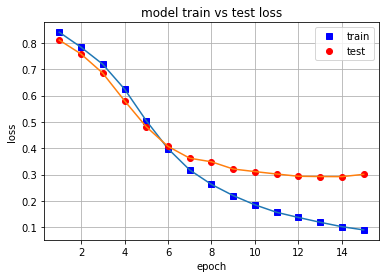

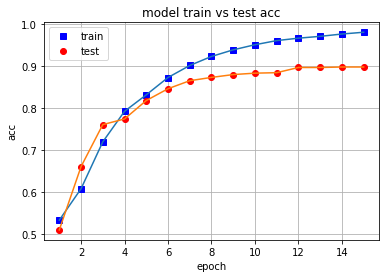

In [6]:
import matplotlib.pyplot as plt

def draw(epochs_list,history):
#     plt.plot(history.history['loss'])
#     plt.plot(history.history['val_loss'])
#     pyplot.title('model train vs validation loss')
#     pyplot.ylabel('loss')
#     pyplot.xlabel('epoch')
#     pyplot.legend(['train', 'validation'], loc='upper right')
#     pyplot.show()

    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)  
    plt.plot(epochs_list,history.history['loss'],'bs',label="train")
    plt.plot(epochs_list,history.history['loss'])
    plt.plot(epochs_list,history.history['val_loss'],'ro',label="test")
    plt.plot(epochs_list,history.history['val_loss'])

    ax.set_title('model train vs test loss')
    ax.set_ylabel('loss')
    ax.set_xlabel('epoch')
    plt.legend(loc=0,ncol=1)
    plt.grid(True)
    plt.show()
    
    fig1=plt.figure()
    ax1=fig1.add_subplot(1,1,1)  
    plt.plot(epochs_list,history.history['acc'],'bs',label="train")
    plt.plot(epochs_list,history.history['acc'])
    plt.plot(epochs_list,history.history['val_acc'],'ro',label="test")
    plt.plot(epochs_list,history.history['val_acc'])
    
    
    ax1.set_title('model train vs test acc')
    ax1.set_ylabel('acc')
    ax1.set_xlabel('epoch')

    plt.legend(loc=0,ncol=1)
    plt.grid(True)
    plt.show()
    
draw(epochs_list,history)

In [7]:
def show(MAX_SENTENCE_LENGTH,model,Xtest,ytest,X,X_sentence):
    
    count=0  #测试正确的样本数
    test_num=10  #测试样本数
    X=X.tolist()
    X_sentence=X_sentence.tolist()
    
    print('{}   {}      {}                          {}'.format('预测','真实','概率','原始句子'))
    for i in range(test_num):
        idx = np.random.randint(len(Xtest))
        xtest = Xtest[idx].reshape(1,MAX_SENTENCE_LENGTH) #model之前的训练数据都是同一维度的，
                                                    #所以统一维度保证model.predict正确
        ylabel = ytest[idx]
        ypred = model.predict(xtest)[0][0] #sigmoid函数输出概率值
        if int(ylabel)==int(round(ypred)):
            count+=1
        xtest=xtest.tolist()
        
#         print(xtest[0])
#         print(type(xtest[0]))
#         print(type(X))
#         print(type(X_sentence))
#         print(X)
#         print(X_sentence)
#         print(xtest)
        
        sent_raw=X_sentence[X.index(xtest[0])]
        ypred=float('%.2f' % ypred)
        print(' {}      {}     {}           {}'.format(int(round(ypred)), int(ylabel), ypred,sent_raw))
    ratio=count/test_num*100
    print("测试样本上的准确率是:",str(ratio)+"%")
    
show(MAX_SENTENCE_LENGTH,model,Xtest,ytest,X,X_sentence)


预测   真实      概率                          原始句子
 0      0     0.02           完了，津冀加速失血……
 1      0     0.99           古县 穷的要变化石了
 1      1     0.91           不错啊，赞一个，本人也是电子爱好者，电子工程专业毕业在嘉善某电子公司从事电子设计，现在电子竞赛应该多设计一点AI的，切合生活的，中学生就能有这个成绩真的很不错
 0      0     0.0           朝阳区华严北里2号院京民社区6号楼3单元401室: 1. 群租严重违规超标，常年不关灯有火灾隐患，已发生过火灾；2. 租客昼伏夜出，行径诡异；3. 气味怪异，一直偷开个楼层窗户散味；4. 屋内诡异，每到夜间就有打斗、嘶吼、摔碎东西、歌唱的声响；5. 男女混乱，常有陌生人。@北京12345
 1      1     1.0           要对失能失智空巢老人给予更多的关爱和照料
 1      1     0.98           每次看到这些荒废的电话亭都觉得可惜，这么改造一下真好！
 1      1     1.0           希望环境越来越好，，点赞
 0      0     0.0           朝阳区华严北里2号院京民社区6号楼3单元401室: 1. 群租严重违规超标，常年不关灯有火灾隐患，已发生过火灾；2. 租客昼伏夜出，行径诡异；3. 气味怪异，一直偷开个楼层窗户散味；4. 屋内诡异，每到夜间就有打斗、嘶吼、摔碎东西、歌唱的声响；5. 男女混乱，常有陌生人。@北京12345
 0      0     0.05           哦 呵呵
 0      0     0.0           朝阳区华严北里2号院京民社区6号楼3单元401室: 1. 群租严重违规超标，常年不关灯有火灾隐患，已发生过火灾；2. 租客昼伏夜出，行径诡异；3. 气味怪异，一直偷开个楼层窗户散味；4. 屋内诡异，每到夜间就有打斗、嘶吼、摔碎东西、歌唱的声响；5. 男女混乱，常有陌生人。@北京12345
测试样本上的准确率是: 90.0%


In [ ]:
#预测所有数据的标签
def Label_Predict(MAX_SENTENCE_LENGTH,model,X,X_sentence,left,right):
    
    Xx=X.tolist()
    X_sentence=X_sentence.tolist()
    
    #print('{}                                                                 {}           {}'.format('句子','概率值','标签'))
    
    lines=[]
    for i in range(left,right):
        line=[]
        xtest = X[i].reshape(1,MAX_SENTENCE_LENGTH) #model之前的训练数据都是同一维度的，
                                                    #所以统一维度保证model.predict正确
        ypred = model.predict(xtest)[0][0] #sigmoid函数输出概率值
        xtest=xtest.tolist()
        sent_raw=X_sentence[Xx.index(xtest[0])]
        ypred=float('%.2f' % ypred)
        label=int(round(ypred))
        if len(sent_raw)==0 or sent_raw=='':
            line.append('空')
        else:
            line.append(sent_raw)
        line.append(str(ypred))
        line.append(str(label))
        lines.append(line)
    return lines
        #print(' {}                                                          {}             {}'.format(sent_raw,ypred,label))
        
    



In [ ]:
path='/Users/lyj/Desktop/所有打标数据/轨道交通.txt'

f=open(path,'w+',encoding='utf-8')

##############################
print(2)
lines=Label_Predict(MAX_SENTENCE_LENGTH,model,X,X_sentence,151427,151781)
for line in lines:
    print(line)
    f.write(' '.join(line))
    f.write('\n')
lines=Label_Predict(MAX_SENTENCE_LENGTH,model,X,X_sentence,157550,157725)
for line in lines:
    print(line)
    f.write(' '.join(line))
    f.write('\n')
##############################
print(3)
lines=Label_Predict(MAX_SENTENCE_LENGTH,model,X,X_sentence,151781,152372)
for line in lines:
    f.write(' '.join(line))
    f.write('\n')
lines=Label_Predict(MAX_SENTENCE_LENGTH,model,X,X_sentence,157725,157944)
for line in lines:
    f.write(' '.join(line))
    f.write('\n')
##############################
print(4)
lines=Label_Predict(MAX_SENTENCE_LENGTH,model,X,X_sentence,152372,153359)
for line in lines:
    f.write(' '.join(line))
    f.write('\n')
lines=Label_Predict(MAX_SENTENCE_LENGTH,model,X,X_sentence,157944,158334)
for line in lines:
    f.write(' '.join(line))
    f.write('\n')
##############################
print(5)
lines=Label_Predict(MAX_SENTENCE_LENGTH,model,X,X_sentence,153359,154220)
for line in lines:
    f.write(' '.join(line))
    f.write('\n')
lines=Label_Predict(MAX_SENTENCE_LENGTH,model,X,X_sentence,158334,158752)
for line in lines:
    f.write(' '.join(line))
    f.write('\n')
##############################
print(6)
lines=Label_Predict(MAX_SENTENCE_LENGTH,model,X,X_sentence,154220,154870)
for line in lines:
    f.write(' '.join(line))
    f.write('\n')
lines=Label_Predict(MAX_SENTENCE_LENGTH,model,X,X_sentence,158752,159091)
for line in lines:
    f.write(' '.join(line))
    f.write('\n')
##############################
print(7)
lines=Label_Predict(MAX_SENTENCE_LENGTH,model,X,X_sentence,154870,155875)
for line in lines:
    f.write(' '.join(line))
    f.write('\n')
lines=Label_Predict(MAX_SENTENCE_LENGTH,model,X,X_sentence,159091,159177)
for line in lines:
    f.write(' '.join(line))
    f.write('\n')
##############################
print(8)
lines=Label_Predict(MAX_SENTENCE_LENGTH,model,X,X_sentence,155875,156538)
for line in lines:
    f.write(' '.join(line))
    f.write('\n')
lines=Label_Predict(MAX_SENTENCE_LENGTH,model,X,X_sentence,159177,159513)
for line in lines:
    f.write(' '.join(line))
    f.write('\n')
##############################
print(9)
lines=Label_Predict(MAX_SENTENCE_LENGTH,model,X,X_sentence,156538,157142)
for line in lines:
    f.write(' '.join(line))
    f.write('\n')
lines=Label_Predict(MAX_SENTENCE_LENGTH,model,X,X_sentence,159513,160964)
for line in lines:
    f.write(' '.join(line))
    f.write('\n')
##############################
print(10)
lines=Label_Predict(MAX_SENTENCE_LENGTH,model,X,X_sentence,157142,157350)
for line in lines:
    f.write(' '.join(line))
    f.write('\n')
lines=Label_Predict(MAX_SENTENCE_LENGTH,model,X,X_sentence,160964,161042)
for line in lines:
    f.write(' '.join(line))
    f.write('\n')
##############################
print(11)
lines=Label_Predict(MAX_SENTENCE_LENGTH,model,X,X_sentence,157350,157550)
for line in lines:
    f.write(' '.join(line))
    f.write('\n')
lines=Label_Predict(MAX_SENTENCE_LENGTH,model,X,X_sentence,161042,161187)
for line in lines:
    f.write(' '.join(line))
    f.write('\n')
##############################
print(12)
lines=Label_Predict(MAX_SENTENCE_LENGTH,model,X,X_sentence,157550,157550)
for line in lines:
    f.write(' '.join(line))
    f.write('\n')
lines=Label_Predict(MAX_SENTENCE_LENGTH,model,X,X_sentence,161187,161192)
for line in lines:
    f.write(' '.join(line))
    f.write('\n')

f.close()